# PixelCNN blind spots

*Note: Here we are using float64 to get more precise values of the gradients and avoid false values.

In [1]:
import random as rn

import matplotlib
import matplotlib.pyplot as plt
from  matplotlib.ticker import FixedLocator
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import nn
from tensorflow.keras import initializers
from tensorflow.keras.utils import Progbar

tf.keras.backend.set_floatx('float64')

In [2]:
class MaskedConv2D(keras.layers.Layer):
    """Convolutional layers with masks.

    Convolutional layers with simple implementation of masks type A and B for
    autoregressive models.

    Arguments:
    mask_type: one of `"A"` or `"B".`
    filters: Integer, the dimensionality of the output space
        (i.e. the number of output filters in the convolution).
    kernel_size: An integer or tuple/list of 2 integers, specifying the
        height and width of the 2D convolution window.
        Can be a single integer to specify the same value for
        all spatial dimensions.
    strides: An integer or tuple/list of 2 integers,
        specifying the strides of the convolution along the height and width.
        Can be a single integer to specify the same value for
        all spatial dimensions.
        Specifying any stride value != 1 is incompatible with specifying
        any `dilation_rate` value != 1.
    padding: one of `"valid"` or `"same"` (case-insensitive).
    kernel_initializer: Initializer for the `kernel` weights matrix.
    bias_initializer: Initializer for the bias vector.
    """

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros'):
        super(MaskedConv2D, self).__init__()

        assert mask_type in {'A', 'B'}
        self.mask_type = mask_type

        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding.upper()
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        self.kernel = self.add_weight('kernel',
                                      shape=(self.kernel_size,
                                             self.kernel_size,
                                             int(input_shape[-1]),
                                             self.filters),
                                      initializer=self.kernel_initializer,
                                      trainable=True)

        self.bias = self.add_weight('bias',
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer,
                                    trainable=True)

        center = self.kernel_size // 2

        mask = np.ones(self.kernel.shape, dtype=np.float64)
        mask[center, center + (self.mask_type == 'B'):, :, :] = 0.
        mask[center + 1:, :, :, :] = 0.

        self.mask = tf.constant(mask, dtype=tf.float64, name='mask')

    def call(self, input):
        masked_kernel = tf.math.multiply(self.mask, self.kernel)
        x = nn.conv2d(input,
                      masked_kernel,
                      strides=[1, self.strides, self.strides, 1],
                      padding=self.padding)
        x = nn.bias_add(x, self.bias)
        return x

And now, we define the residual block.

*Note: Here we removed the ReLU activations to not mess with the gradients while we are investigating them.

In [3]:
class ResidualBlock(keras.Model):
    """Residual blocks that compose pixelCNN

    Blocks of layers with 3 convolutional layers and one residual connection.
    Based on Figure 5 from [1] where h indicates number of filters.

    Refs:
    [1] - Oord, A. V. D., Kalchbrenner, N., & Kavukcuoglu, K. (2016). Pixel recurrent
    neural networks. arXiv preprint arXiv:1601.06759.
    """

    def __init__(self, h):
        super(ResidualBlock, self).__init__(name='')

        self.conv2a = keras.layers.Conv2D(filters=h, kernel_size=1, strides=1)
        self.conv2b = MaskedConv2D(mask_type='B', filters=h, kernel_size=3, strides=1)
        self.conv2c = keras.layers.Conv2D(filters=2 * h, kernel_size=1, strides=1)

    def call(self, input_tensor):
#         x = nn.relu(input_tensor)
#         x = self.conv2a(x)
        x = self.conv2a(input_tensor)

#         x = nn.relu(x)
        x = self.conv2b(x)

#         x = nn.relu(x)
        x = self.conv2c(x)

        x += input_tensor
        return x

In [4]:
height = 10
width = 10
n_channel = 1

data = tf.random.normal((1, height, width, n_channel))

inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=1, kernel_size=3, strides=1)(inputs)
model = tf.keras.Model(inputs=inputs, outputs=x)

In [5]:
def plot_receptive_field(model, data):
    with tf.GradientTape() as tape:
        tape.watch(data)
        prediction = model(data)
        loss = prediction[:,5,5,0]

    gradients = tape.gradient(loss, data)

    gradients = np.abs(gradients.numpy().squeeze())
    gradients = (gradients > 0).astype('float64')
    gradients[5, 5] = 0.5

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    plt.xticks(np.arange(0, 10, step=1))
    plt.yticks(np.arange(0, 10, step=1))
    ax.xaxis.set_minor_locator(FixedLocator(np.arange(0.5, 10.5, step=1)))
    ax.yaxis.set_minor_locator(FixedLocator(np.arange(0.5, 10.5, step=1)))
    plt.grid(which="minor")
    plt.imshow(gradients, vmin=0, vmax=1)
    plt.show()

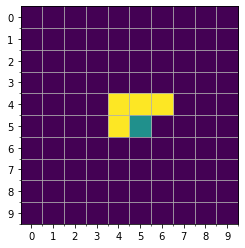

In [6]:
plot_receptive_field(model, data)

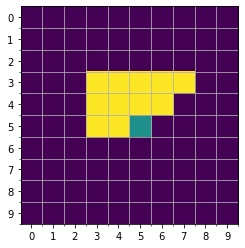

In [7]:
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=1, kernel_size=3, strides=1)(inputs)
x = ResidualBlock(h=1)(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

plot_receptive_field(model, data)

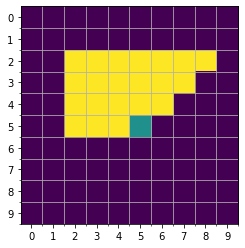

In [8]:
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=1, kernel_size=3, strides=1)(inputs)
x = ResidualBlock(h=1)(x)
x = ResidualBlock(h=1)(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

plot_receptive_field(model, data)

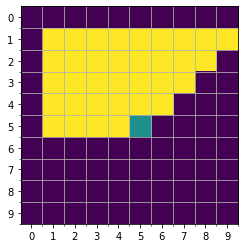

In [9]:
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=1, kernel_size=3, strides=1)(inputs)
x = ResidualBlock(h=1)(x)
x = ResidualBlock(h=1)(x)
x = ResidualBlock(h=1)(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

plot_receptive_field(model, data)

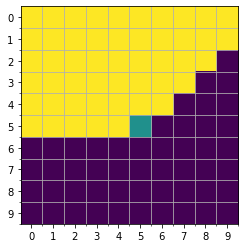

In [10]:
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=1, kernel_size=3, strides=1)(inputs)
x = ResidualBlock(h=1)(x)
x = ResidualBlock(h=1)(x)
x = ResidualBlock(h=1)(x)
x = ResidualBlock(h=1)(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

plot_receptive_field(model, data)